In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datasets import Dataset, DatasetDict
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertForSequenceClassification

from sklearn.metrics import classification_report, log_loss, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader

In [ ]:
TOKEN = 'TOKEN_HUGGING_FACE'
login(token=TOKEN)

# BERT

## Preprocessing

In [21]:
# data = pd.read_excel('Datos_Totales.xlsx')
data = pd.read_excel('Data_Final.xlsx')
data['label'] = np.where(data['Categoria'] == 'Humor', 1, 0)
data = data[['Texto', 'Dataset', 'label']]
data = data.rename(columns={'Texto': 'text'})

In [22]:
def preprocessing(text):
    text = text.replace('\n', ' ')
    return text

data['text'] = data['text'].apply(preprocessing)

In [23]:
data.head()

,text,Dataset,label
0,"- ¡Rápido, necesitamos sangre! - Yo soy 0 posi...",test,1
1,- ¿Cuál es el mejor portero del mundial? - Ev...,train-val,1
2,El otro día unas chicas llamarón a mi puerta y...,test,1
3,"- Andresito, ¿qué planeta va después de Marte?...",train-val,1
4,- ¿Por qué Bob Esponja no va al gimnasio? - P...,train-val,1


In [24]:
data['label'].value_counts()

,count
label,
1,6012
0,5048


In [9]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'text': val_texts, 'label': val_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

In [25]:
data_train_val = data[data['Dataset'] == 'train-val']

In [26]:
data_train_val.shape

(9060, 3)

In [27]:
# Dividir en train (80%), validación (10%) y test (10%)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data_train_val['text'], data_train_val['label'], test_size=0.23, random_state=42, stratify=data_train_val['label']
)

# Convertir a DataFrames
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'text': val_texts, 'label': val_labels})

test_df = data[data['Dataset'] == 'test']

In [28]:
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6976
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2084
    })
    test: Dataset({
        features: ['text', 'Dataset', 'label'],
        num_rows: 2000
    })
})


## Tokenizer

In [29]:
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

In [30]:
def tokenize_function(row):
    tokenized_text = tokenizer(row['text'], padding='max_length', truncation=True, max_length=256)
    return tokenized_text

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/6976 [00:00<?, ? examples/s]

Map:   0%|          | 0/2084 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [31]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6976
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2084
    })
    test: Dataset({
        features: ['text', 'Dataset', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [32]:
tokenized_dataset['train'].column_names

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']

## BERT Model

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [34]:
model_name = 'dccuchile/bert-base-spanish-wwm-cased'
model = AutoModel.from_pretrained(model_name, num_labels=2).to(device)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
text = "This is a test"
sample_inputs = tokenizer(text, return_tensors='pt')
print(f"Input tensor shape: {sample_inputs['input_ids'].size()}\n")
print(f"Tokenized text: {tokenizer.convert_ids_to_tokens(sample_inputs['input_ids'][0])}")

Input tensor shape: torch.Size([1, 6])

Tokenized text: ['[CLS]', 'This', 'is', 'a', 'test', '[SEP]']


In [36]:
inputs = {k: v.to(device) for k, v in sample_inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    print(outputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.1789,  0.4852,  0.0491,  ..., -0.3944,  0.1194, -0.1034],
         [-0.6695,  0.1278,  0.0278,  ..., -0.0819,  0.4755,  0.5748],
         [-0.8985,  0.5522,  0.3598,  ..., -0.2074, -0.1881, -0.4647],
         [-0.3290,  0.9780, -0.1741,  ..., -0.2156, -0.6462,  0.2847],
         [-0.3186,  0.3592, -0.7062,  ...,  0.1570,  0.2133,  0.1594],
         [-1.1750,  0.1254, -0.2510,  ...,  0.0739,  0.5466,  0.2637]]],
       device='cuda:0'), pooler_output=tensor([[ 4.0282e-01,  2.0504e-02, -1.7060e-01, -3.8140e-01, -3.0990e-02,
          5.4542e-01,  3.9171e-02,  5.9387e-01, -2.9997e-01, -7.0809e-01,
          4.2545e-01, -2.4452e-02,  3.8178e-02, -4.7249e-01, -4.9280e-01,
         -1.1492e-02,  3.9360e-02, -1.7644e-01, -2.3969e-02,  4.5760e-01,
          3.4887e-01, -1.0115e-02,  5.9187e-01, -2.5865e-02,  3.5309e-01,
          2.2400e-01, -2.2940e-02,  5.1453e-01, -4.9265e-01,  1.6695e-03,
         -4.0941e-02, -1.1

In [37]:
outputs.last_hidden_state[:, 0].shape

torch.Size([1, 768])

In [38]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {'hidden state': last_hidden_state[:, 0].cpu().numpy()}

In [39]:
tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [40]:
hidden_dataset = tokenized_dataset.map(extract_hidden_states, batched=True, batch_size=16)

Map:   0%|          | 0/6976 [00:00<?, ? examples/s]

Map:   0%|          | 0/2084 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [41]:
hidden_dataset['train'].column_names

['text',
 'label',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'hidden state']

## Classifier Model

In [43]:
X_train = np.array(hidden_dataset['train']['hidden state'])
X_valid = np.array(hidden_dataset['validation']['hidden state'])
X_test = np.array(hidden_dataset['test']['hidden state'])
y_train = np.array(hidden_dataset['train']['label'])
y_valid = np.array(hidden_dataset['validation']['label'])
y_test = np.array(hidden_dataset['test']['label'])

print(X_train.shape, X_valid.shape, X_test.shape)

(6976, 768) (2084, 768) (2000, 768)


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.9816425120772947

In [ ]:
y_pred = lr_clf.predict(X_valid)

In [ ]:
target_names = ['No Humor', 'Humor']
print(classification_report(y_valid, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.98      0.98      0.98       512
       Humor       0.98      0.98      0.98       523

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



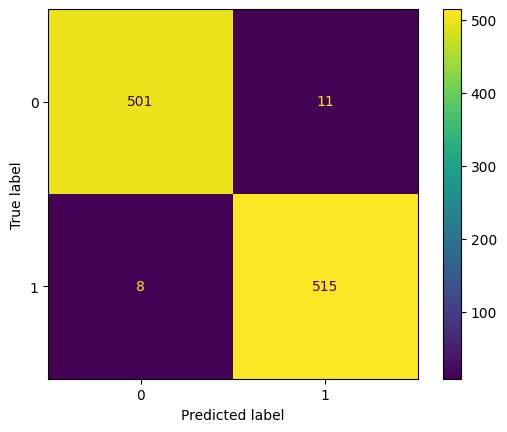

In [ ]:
cm = confusion_matrix(y_valid, y_pred, labels=lr_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_clf.classes_)
disp.plot()
plt.show()

### MLP Classifier

In [54]:
clf = MLPClassifier(hidden_layer_sizes=(5,), max_iter=1, warm_start=True, solver='adam', random_state=42)

train_losses = []
val_losses = []

for epoch in range(50):
    clf.fit(X_train, y_train)

    y_train_prob = clf.predict_proba(X_train)
    y_val_prob = clf.predict_proba(X_valid)

    train_losses.append(log_loss(y_train, y_train_prob))
    val_losses.append(log_loss(y_valid, y_val_prob))

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

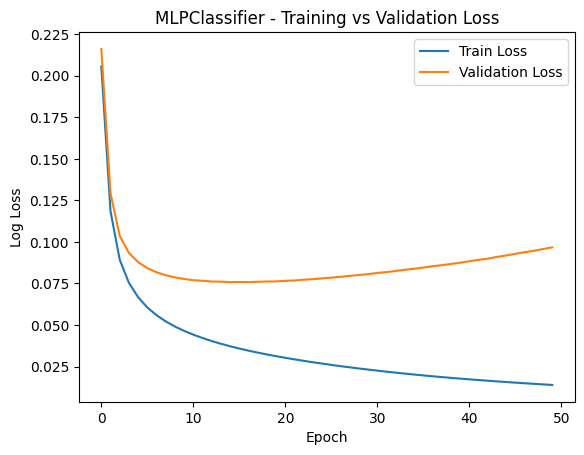

In [55]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("MLPClassifier - Training vs Validation Loss")
plt.legend()
plt.show()

In [56]:
y_pred = clf.predict(X_test)

In [58]:
target_names = ['No Humor', 'Humor']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.95      0.98      0.96       804
       Humor       0.98      0.96      0.97      1196

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



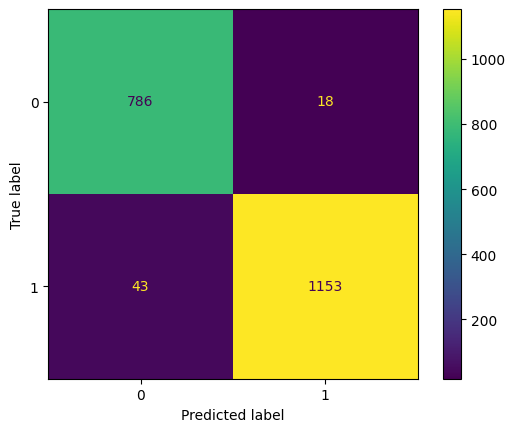

In [60]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Stress Testing

In [ ]:
textos = [
    "Hombre pregunta mujer como va como casa",
    "Pregunta mujer va",
    "Ya nos encontramos en Lepe, una vez estemos alli",
    """No sabes como necesito tu voz;
    necesito tus miradas
    aquellas palabras que siempre me llenaban,
    necesito tu paz interior;
    necesito la luz de tus labios
    !!! Ya no puedo... seguir así !!!
    ...Ya... No puedo""",
    "Lionel Messi es un gran jugador jajaja",
    "¿Por qué Bob Esponja no va al gimnasio? Porque ya está cuadrado."
]

categorias = ['0', '0', '0', '0', '0', '1']

df_stress = pd.DataFrame({
    'text': textos,
    'label': categorias
})

st_dataset = Dataset.from_pandas(df_stress)

st_encoded = st_dataset.map(tokenize_function, batched=True, batch_size=None)
st_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

st_hidden = st_encoded.map(extract_hidden_states, batched=True, batch_size=8)

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

In [70]:
df_stress = pd.read_excel('stress_testing_data.xlsx')
df_stress = df_stress.rename(columns={'Texto': 'text'})
df_stress['label'] = np.where(df_stress['Categoria'] == 'Humor', 1, 0)
df_stress = df_stress.drop(['ID', 'Categoria'], axis=1)
df_stress['text'] = df_stress['text'].apply(preprocessing)

st_dataset = Dataset.from_pandas(df_stress)

st_encoded = st_dataset.map(tokenize_function, batched=True, batch_size=None)
st_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

st_hidden = st_encoded.map(extract_hidden_states, batched=True, batch_size=16)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [71]:
df_stress.head()

,text,label
0,Hombre le pregunta a su mujer como va a casa,0
1,"Señor, ¿usted tiene hijos? —preguntó el niño. ...",0
2,Un niño observaba a un hombre mayor en la plaz...,0
3,"Jaimito le hace una pregunta a su madre: Mamá,...",0
4,Pregunta pregunta pregunta pregunta pregunta p...,0


In [72]:
st_hidden.column_names

['text',
 'label',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'hidden state']

In [73]:
X_st = np.array(st_hidden['hidden state'])
y_st = np.array(st_hidden['label']).astype(int)

In [74]:
y_pred_st = clf.predict(X_st)
y_pred_st

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1])

In [75]:
print(classification_report(y_st, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.71      0.44      0.54        50
       Humor       0.59      0.82      0.69        50

    accuracy                           0.63       100
   macro avg       0.65      0.63      0.62       100
weighted avg       0.65      0.63      0.62       100



# Custom Dataset

In [ ]:
def tokenize_function(text):
    tokenized_text = tokenizer(text, padding='max_length', truncation=True, max_length=256, return_tensors='pt')
    return tokenized_text

data['tokenized'] = data['text'].apply(lambda x: tokenize_function(x))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
dataset = CustomDataset(data['text'].tolist(), data['label'].tolist(), tokenizer)

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'dccuchile/bert-base-spanish-wwm-uncased',
    num_labels=2
)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Training Loss: {total_loss / len(train_loader)}")

Epoch 1/3


KeyboardInterrupt: 